In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_context('notebook')

### define model 

*using model notation*

-----------

$$ h_1 = W_1 x_0 \\
x_1 = \operatorname{tanh}(h_1) \\ 
x_2 = W_2x_2$$

where
$$x_0\in\mathbb{R}^{n_0} \\
h_1\in\mathbb{R}^{n_1} \\
x_1\in\mathbb{R}^{n_1} \\
x_2\in\mathbb{R}^{n_2}$$

In [2]:
# model parameters
n0 = 5 # input dimension / number of input units
n1 = 10 # hidden dimension / number of hidden layer units
n2 = 1  # output dimension
W1 = 1/np.sqrt(n1)*np.random.randn(n1, n0) # input to hidden. n1 x n0 iid Guassian
W2 = 1/np.sqrt(n1)*np.random.randn(n2, n1) # hidden to output. n2 x n1 iid Gaussian

# inputs
num_examples = 20
x0 = np.random.randn(n0, num_examples) # n0 x num_examples matrix

In [3]:
# forward pass on the model
h1 = np.dot( W1, x0 )
x1 = np.tanh( h1 )
x2 = np.dot( W2, x1 )

### define inverse functions

*using generic notation*

------------

`x = linear_inv(y, x_0, A)` implements

$$x = x_0 - A^\dagger A x_0 + A^\dagger y$$

In [4]:
def linear_inv(y, x_0, A):
  Apinv = np.linalg.pinv(A)
  return x_0 - np.dot(Apinv, np.dot(A, x_0)) + np.dot(Apinv, y)

---------------
`x = linear_rinv(y, x_0, A, gamma)` implements

$$ x = (A^\top A + \gamma I)^{-1}(A^\top y + \gamma x_0) $$

In [5]:
def linear_rinv(y, x_0, A, gamma=1e-2):
  return np.dot( np.linalg.inv(np.dot(A.T, A) + gamma*np.eye(x_0.shape[0])), np.dot(A.T, y) + gamma*x_0 )

--------------
`x = tanh_inv(y, x_0, th)` implements (note, `x_0` is note used)

$$ x = \operatorname{tanh}^{-1}(y) = \frac 1 2 \log (\frac{1+y}{1-y})$$
for $y\in[-1+\epsilon, 1-\epsilon]$. Here, `th`=$\epsilon$. 

For $y<-1+\epsilon$, the function returns $x = \operatorname{tanh}^{-1}(-1+\epsilon)$

For $y>1-\epsilon$, the function returns $x = \operatorname{tanh}^{-1}(1-\epsilon)$

In [6]:
def tanh_inv(y, x_0=None, th=1e-2):
  y = np.piecewise(y, [y <= (-1+th), y > (-1+th), y >= (1-th)], [-1+th, lambda y_: y_, 1-th])
  return 0.5*np.log((1. + y)/(1. - y))

---------------
`x = tanh_rinv(y, x_0, gamma)` implements the solution to

\begin{align}
  x & = \underset{\tilde{x}}{\operatorname{argmin}} \| \operatorname{tanh}(\tilde{x}) - y \|_2^2 + \gamma \| \tilde{x} - x_0 \|_2^2
\end{align}

using a scipy's `fmin` function. 

In [7]:
def tanh_rinv(y, x_0, gamma=1e-2):
  from scipy.optimize import fmin
  def cost(x_tilde, y, x_0):
    return np.sum((np.tanh(x_tilde) - y)**2 + gamma*(x_tilde - x_0)**2, axis=0)
  x = tanh_inv(y, x_0, th=1e-2)
  for i in range(y.shape[1]):
    x[:, i] = fmin(cost, x[:, i], args=(y[:, i], x_0[:, 1]), xtol=1e-5, ftol=1e-5, maxiter=50, disp=0)
  return x

### train model
------------

In [8]:
W1_est = 1/np.sqrt(n1)*np.random.randn(n1, n0) # initialization of W1

In [9]:
# forward pass
h1_est = np.dot( W1_est, x0 )
x1_est = np.tanh( h1_est )
x2_est = np.dot( W2, x1_est )
loss_old = 0.5*np.mean((x2_est - x2)**2)
print "loss_old", loss_old

loss_old 0.300266583913


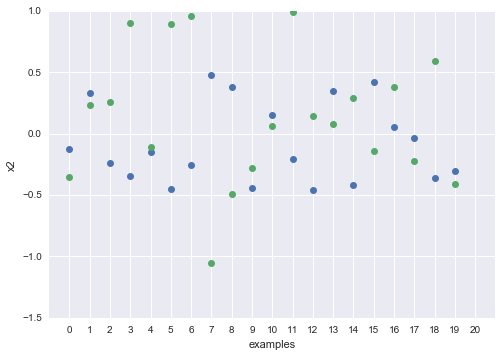

data=blue, estimates=green


In [10]:
f = plt.plot(x2.T,'o')[0]
plt.plot(x2_est.T,'o')
plt.xlim([-1, num_examples+1])
f.axes.xaxis.set_ticks(np.arange(0, num_examples+1))
plt.xlabel('examples')
plt.ylabel('x2')
plt.show()
print "data=blue, estimates=green"

In [11]:
# backward pass.
x1_target = linear_inv( x2, x1_est, W2 )
h1_target = tanh_inv( x1_target, h1_est, 1e-3 )
W1_est = linear_inv( h1_target.T, W1_est.T, x0.T ).T # note, we have to transpose all the inputs, then transpose the output of linear_inv()

In [12]:
# forward pass
h1_est = np.dot( W1_est, x0 )
x1_est = np.tanh( h1_est )
x2_est = np.dot( W2, x1_est )
loss_new = 0.5*np.mean((x2_est - x2)**2)

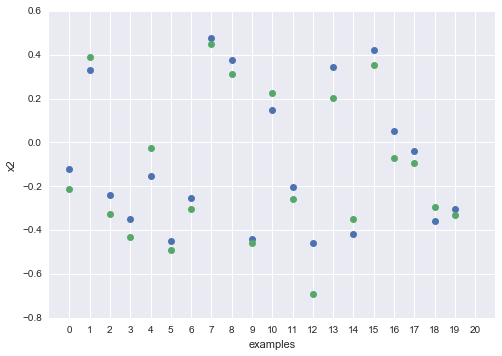

data=blue, estimates=green


In [13]:
f = plt.plot(x2.T,'o')[0]
plt.plot(x2_est.T,'o')
plt.xlim([-1, num_examples+1])
f.axes.xaxis.set_ticks(np.arange(0, num_examples+1))
plt.xlabel('examples')
plt.ylabel('x2')
plt.show()
print "data=blue, estimates=green"

In [14]:
print "loss_old", loss_old
print "loss_new", loss_new

loss_old 0.300266583913
loss_new 0.00412842521769


In [15]:
# # use for later...
# fig = plt.figure(figsize=(20,5))

# ax = []
# ax.append(fig.add_subplot(1,4,1))
# ax[0].scatter(x0[0,:], x0[1,:], c=range(num_examples)), ax[0].axis('square')

# ax.append(fig.add_subplot(1,4,2, projection='3d'))
# ax[1].scatter(h1[0,:], h1[1,:], h1[2,:], c=range(num_examples)), ax[1].axis('square')

# ax.append(fig.add_subplot(1,4,3, projection='3d'))
# ax[2].scatter(x1[0,:], x1[1,:], x1[2,:], c=range(num_examples)), ax[2].axis('square')

# ax.append(fig.add_subplot(1,4,4))
# ax[3].scatter(range(num_examples), x2.T, c=range(num_examples)), ax[2].axis('square')

# plt.show()